<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/dl-time-series-forecasting/blob/main/LSTM_Multivariat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!git clone https://github.com/Soedirman-Machine-Learning/dl-time-series-forecasting

Cloning into 'dl-time-series-forecasting'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 118 (delta 52), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (118/118), 2.11 MiB | 11.67 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [1]:
import io
import math
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential 
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data2=pd.read_csv('https://raw.githubusercontent.com/Soedirman-Machine-Learning/dl-time-series-forecasting/main/dataset_multivariat.csv')
data2

,u1,u2,u3,u4,u5,u6,u7,y
0,0.268900,0.650894,0.832742,0.583420,0.784759,0.843079,0.822079,0.180295
1,0.268483,0.650140,0.852153,0.577510,0.776487,0.838605,0.822079,0.177124
2,0.267967,0.659657,0.823618,0.571600,0.764546,0.807879,0.786246,0.173618
3,0.267451,0.668338,0.808371,0.565689,0.752605,0.799606,0.786246,0.171640
4,0.266935,0.647191,0.761948,0.559779,0.745326,0.773122,0.746142,0.166972
...,...,...,...,...,...,...,...,...
2389,0.284859,0.645894,0.688723,0.355109,0.615583,0.608848,0.500866,0.188976
2390,0.266139,0.665503,0.665640,0.354275,0.588834,0.582074,0.508999,0.178992
2391,0.247419,0.665706,0.664740,0.353441,0.561301,0.602186,0.523348,0.169742
2392,0.228699,0.672975,0.677300,0.352607,0.530730,0.636970,0.537697,0.159023


In [3]:
df=pd.DataFrame(data2)

In [4]:
df.head()

,u1,u2,u3,u4,u5,u6,u7,y
0,0.268900,0.650894,0.832742,0.583420,0.784759,0.843079,0.822079,0.180295
1,0.268483,0.650140,0.852153,0.577510,0.776487,0.838605,0.822079,0.177124
2,0.267967,0.659657,0.823618,0.571600,0.764546,0.807879,0.786246,0.173618
3,0.267451,0.668338,0.808371,0.565689,0.752605,0.799606,0.786246,0.171640
4,0.266935,0.647191,0.761948,0.559779,0.745326,0.773122,0.746142,0.166972


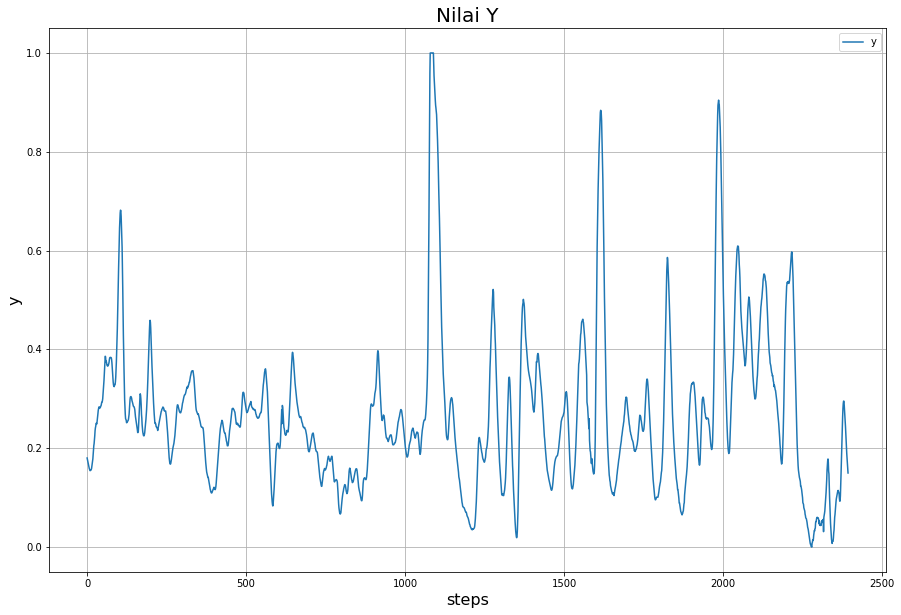

In [5]:
plt.figure(figsize=(15,10))
plt.ylabel('y', fontsize=16)
plt.xlabel('steps',fontsize=16)
plt.title("Nilai Y", fontsize=20)
plt.plot(df['y'])
plt.legend(['y'])
plt.grid(True)
plt.show()

In [6]:
data2_perc_change=df['y']

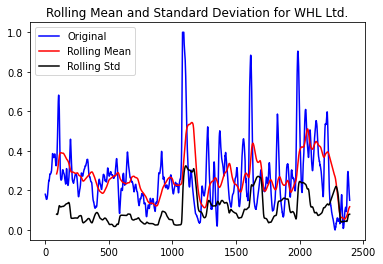


Results of Dickey Fuller Test
Test Statistics               -6.621370e+00
p-value                        6.025309e-09
No. of lags used               1.400000e+01
Number of observations used    2.379000e+03
critical value(1%)            -3.433102e+00
critical value(5%)            -2.862756e+00
critical value(10%)           -2.567417e+00
dtype: float64


In [7]:
#Uji Stasioneritas

rolmean2=data2_perc_change.rolling(90).mean()
rolstd2=data2_perc_change.rolling(90).std()


plt.plot(data2_perc_change,color='blue',label='Original')
plt.plot(rolmean2, color='red',label='Rolling Mean')
plt.plot(rolstd2,color='black',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation for WHL Ltd.')
plt.show()
print("")
print("Results of Dickey Fuller Test")
adft2=adfuller(data2_perc_change,autolag='AIC')
output2=pd.Series(adft2[0:4],index=['Test Statistics', 'p-value','No. of lags used','Number of observations used'])
for key,values in adft2[4].items():
  output2['critical value(%s)'%key]=values
print(output2)

In [8]:
#Diskripsi Data
df.describe()

,u1,u2,u3,u4,u5,u6,u7,y
count,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000
mean,0.283894,0.667847,0.598467,0.435948,0.658086,0.620741,0.589397,0.267788
std,0.103143,0.057690,0.198581,0.138237,0.127054,0.165116,0.173251,0.158943
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.224004,0.653819,0.500390,0.363369,0.608661,0.481804,0.445001,0.169188
50%,0.263995,0.671915,0.624269,0.396288,0.694644,0.639585,0.600959,0.246857
75%,0.325607,0.690943,0.742784,0.518144,0.730119,0.755050,0.741387,0.318061
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
#showing column wise %ge of NaN values they contains 
for i in df.columns:
  print(i,"\t-\t",df[i].isna().mean()*100)

u1 	-	 0.0
u2 	-	 0.0
u3 	-	 0.0
u4 	-	 0.0
u5 	-	 0.0
u6 	-	 0.0
u7 	-	 0.0
y 	-	 0.0


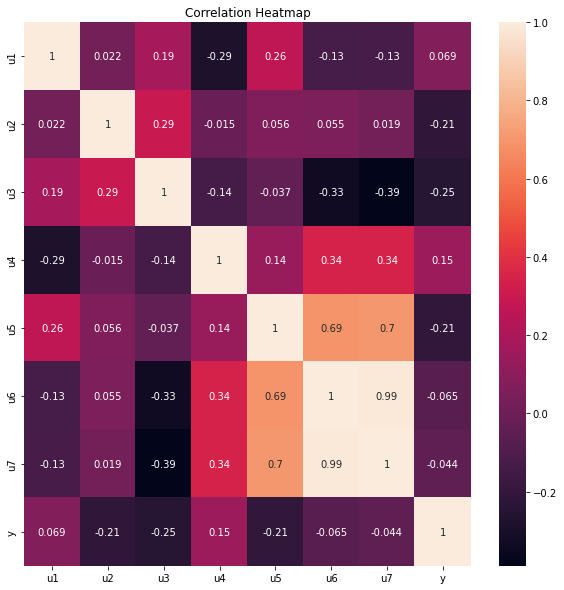

In [10]:
#Representasi grafis dari matriks korelasi
#mewakili korelasi antara variabel yang berbeda
cormap =df.corr()
fig,ax=plt.subplots(figsize=(10,10))
plt.title("Correlation Heatmap")
sns.heatmap(cormap,annot=True)

In [11]:
# List of considered Features
FEATURES = ['u1','u2','u3','u4','u5','u6','u7','y']

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['y']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['u1', 'u2', 'u3', 'u4', 'u5', 'u6', 'u7', 'y']


,u1,u2,u3,u4,u5,u6,u7,y,Prediction
2389,0.284859,0.645894,0.688723,0.355109,0.615583,0.608848,0.500866,0.188976,0.188976
2390,0.266139,0.665503,0.665640,0.354275,0.588834,0.582074,0.508999,0.178992,0.178992
2391,0.247419,0.665706,0.664740,0.353441,0.561301,0.602186,0.523348,0.169742,0.169742
2392,0.228699,0.672975,0.677300,0.352607,0.530730,0.636970,0.537697,0.159023,0.159023
2393,0.215821,0.668945,0.677877,0.351774,0.500161,0.684994,0.569601,0.149922,0.149922


In [12]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['y'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2394, 8)


In [13]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("y")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = 1915

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1865, 50, 8) (1865,)
(479, 50, 8) (479,)
0.30900097
0.30900097


In [14]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

400 50 8


In [15]:
# Training the model
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/50
117/117 [==============================] - 73s 595ms/step - loss: 0.0331 - val_loss: 9.0192e-04
Epoch 2/50
117/117 [==============================] - 70s 601ms/step - loss: 7.8233e-04 - val_loss: 0.0014
Epoch 3/50
117/117 [==============================] - 69s 586ms/step - loss: 4.6260e-04 - val_loss: 0.0015
Epoch 4/50
117/117 [==============================] - 68s 583ms/step - loss: 3.7569e-04 - val_loss: 6.9197e-04
Epoch 5/50
117/117 [==============================] - 68s 581ms/step - loss: 3.2286e-04 - val_loss: 0.0013
Epoch 6/50
117/117 [==============================] - 68s 583ms/step - loss: 2.9479e-04 - val_loss: 7.5643e-04
Epoch 7/50
117/117 [==============================] - 68s 583ms/step - loss: 2.6182e-04 - val_loss: 9.2271e-04
Epoch 8/50
117/117 [==============================] - 68s 585ms/step - loss: 2.2009e-04 - val_loss: 5.8156e-04
Epoch 9/50
117/117 [==============================] - 68s 583ms/step - loss: 2.1473e-04 - val_loss: 4.1334e-04
Epoch 10/50
117/1

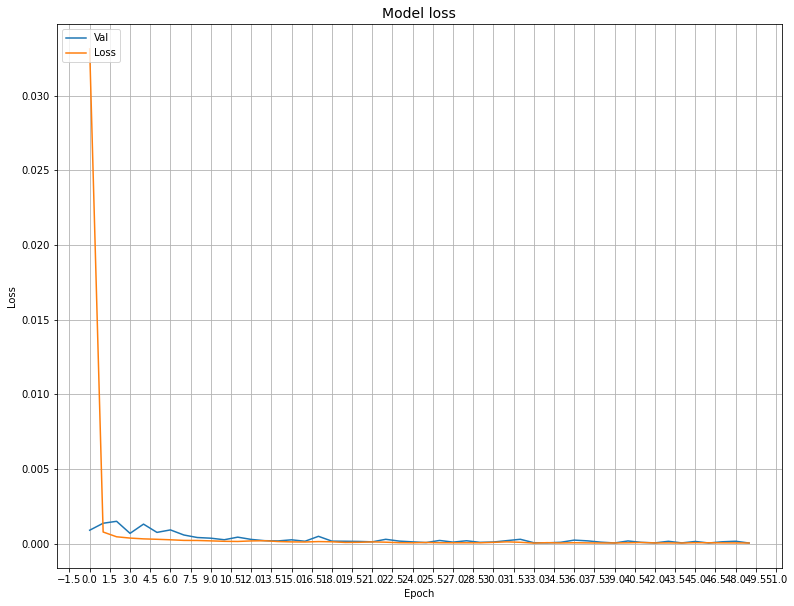

In [16]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(13, 10), sharex=True)
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.title("Model loss",fontsize=14)
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Val", "Loss"], loc="upper left")
plt.grid()
plt.show()


In [20]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

In [18]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_scaled.flatten()})
pred_df

,Actual,Predicted
0,0.270000,0.268126
1,0.257512,0.256997
2,0.246534,0.245562
3,0.233104,0.234986
4,0.228674,0.222622
...,...,...
474,0.188976,0.184954
475,0.178992,0.175289
476,0.169742,0.167399
477,0.159023,0.161337


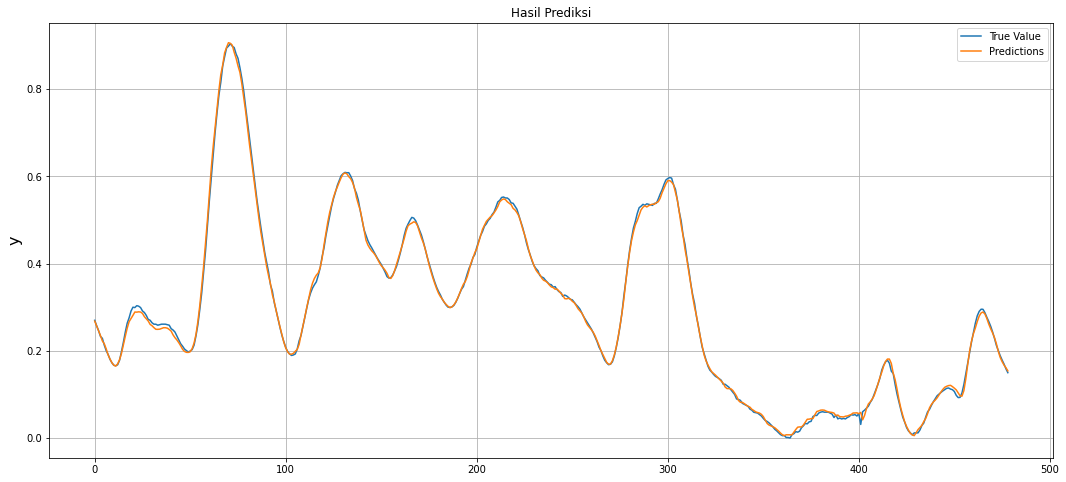

In [19]:
plt.figure(figsize=(18,8))
plt.ylabel('y', fontsize=16)
plt.title("Hasil Prediksi")
plt.plot(pred_df)
plt.grid(True)
plt.legend(['True Value', 'Predictions'])
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/y_test_unscaled ))) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print(f'Root Mean Square Error (RMSE): {np.round(RMSE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE):{np.round(MAPE, 2)} %')

Mean Absolute Error (MAE): 0.0
Median Absolute Percentage Error (MDAPE): 1.53 %
Root Mean Square Error (RMSE): 0.01
Mean Absolute Percentage Error (MAPE):inf %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
